**Cài đặt môi trường**

In [1]:
!pip install -r requirements.txt

  Cloning https://github.com/Farama-Foundation/MAgent2 to /tmp/pip-req-build-p5awfscq
  Running command git clone --filter=blob:none --quiet https://github.com/Farama-Foundation/MAgent2 /tmp/pip-req-build-p5awfscq
  Resolved https://github.com/Farama-Foundation/MAgent2 to commit b2ddd49445368cf85d4d4e1edcddae2e28aa1406
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached torch-2.5.1-cp312-cp312-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pygame-2.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached pettingzoo-1.24.3-py3-none-any.whl.metadata (8.5 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cac

**Import library**

In [ ]:
from magent2.environments import battle_v4
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from copy import deepcopy
import torch.nn as nn
import torch
import numpy as np
import os
import cv2
import math
import random

In [ ]:
# device = 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
env = battle_v4.env(map_size=45, minimap_mode=False, step_reward=-0.01,
                    dead_penalty=-0.1, attack_penalty=-0.1, attack_opponent_reward=0.5,
                    max_cycles=200, extra_features=False)

**Pretrained network**

In [ ]:
class QNetwork_pre(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
        )
        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]
        self.network = nn.Sequential(
            nn.Linear(flatten_dim, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, action_shape),
        )

    def forward(self, x):
        assert len(x.shape) >= 3, "only support magent input observation"
        x = self.cnn(x)
        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]
        x = x.reshape(batchsize, -1)
        return self.network(x)


In [ ]:
q_network_pre = QNetwork_pre(
    (13,13,5), env.action_space("red_0").n).to(device)
q_network_pre.load_state_dict(
    torch.load("red.pt", weights_only=True, map_location=device))

<All keys matched successfully>

**Final Network**

In [ ]:
class QNetwork_final(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
        )
        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]
        self.network = nn.Sequential(
            nn.Linear(flatten_dim, 120),
            # nn.LayerNorm(120),
            nn.ReLU(),
            nn.Linear(120, 84),
            # nn.LayerNorm(84),
            nn.Tanh(),
        )
        self.last_layer = nn.Linear(84, action_shape)

    def forward(self, x):
        assert len(x.shape) >= 3, "only support magent input observation"
        x = self.cnn(x)
        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]
        x = x.reshape(batchsize, -1)
        x = self.network(x)
        self.last_latent = x
        return self.last_layer(x)

**My Network**

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, input_shape, hidden_units, action_shape, dropout_rate = 0.1):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(input_shape,hidden_units,2),
            nn.ReLU(),
            nn.Conv2d(input_shape,hidden_units,2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(p=dropout_rate)  # Dropout
        )
        # self.residual = nn.Conv2d(input_shape, hidden_units, 3, padding= 1)
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(125, 84),
            nn.ReLU(),
            nn.Linear(84, 60),
            nn.ReLU(),
            nn.Linear(60, action_shape),
        )

    def forward(self, x):
        return self.network(self.block1(x))


**Replay Buffer**

In [ ]:
class ReplayBuffer:

    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)
        batch = random.sample(self.memory, batch_size)
        batch = zip(*batch)
        return [torch.cat([item.to(device) for item in items]) for items in batch]
        # return [torch.cat(items) for items in batch]

    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 300

    def __len__(self):
        return len(self.memory)

replay = ReplayBuffer(capacity = 50000)

In [ ]:
# initialize q_network and target q_network
q_network = QNetwork(5, 5, 21).to(device)
target_q_network = deepcopy(q_network).eval()
# test with dummy tensor
dummy_tensor = torch.rand(size = (1,5,13,13))
test = q_network(dummy_tensor.to(device))

In [ ]:
# initialize criterion and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params = q_network.parameters(),
                             lr = 0.0001)

In [ ]:
# set seed
seed = 40

def set_seed(seed):
    # Đặt seed cho Python
    random.seed(seed)
    # Đặt seed cho numpy
    np.random.seed(seed)
    # Đặt seed cho PyTorch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

In [ ]:
def exploratory_policy(state, agent, epsilon, env):
  if random.random() < epsilon:
    return torch.tensor(env.action_space(agent).sample()).view(1,-1)
  else:
    tensor_state = torch.from_numpy(state).permute([2, 0, 1]).unsqueeze(dim = 0)
    action_logits = q_network(tensor_state.to(device)).detach()
    return torch.argmax(action_logits, dim = 1, keepdim = True)

In [ ]:
# preprocess before inserting into buffer replay
def preprocess(state, reward, done, next_state):
  tensor_state = torch.from_numpy(state).permute([2, 0, 1]).unsqueeze(dim = 0).to(device)
  tensor_next_state = torch.from_numpy(next_state).permute([2, 0, 1]).unsqueeze(dim = 0).to(device)
  tensor_reward = torch.tensor(reward).view(1,-1).to(device)
  tensor_done = torch.tensor(done).view(1, -1).to(device)
  return tensor_state, tensor_next_state, tensor_reward, tensor_done

In [ ]:
# pursuit reward
def pursuit(state, next_state, action):
    oppo_presence_prev = state[:,:,4]
    oppo_presence_cur = next_state[:,:,4]
    return 0.015 if (np.sum(oppo_presence_cur != 0) - np.sum(oppo_presence_prev != 0)) > 0 and action not in {3,7,8,11,6} else 0

In [ ]:
# dict for storing state, action, next state 
agents_action = {}
for i in range(81):
    agents_action['blue_' + str(i)] = -1

**Training**

In [ ]:
initial_epsilon = 1
batch_size = 16
gamma = 0.9
episodes = 100
stats = {'Returns': []}
decay_rate = 0.02
final_epsilon = 0.01
best_model_path = "best_model.pt"
best_model_in_episode = 0
tmp_posi_kill = 0

for episode in tqdm(range(episodes)):
  env.reset(seed)
  epsilon = max(final_epsilon, initial_epsilon * math.exp(-decay_rate * episode))
  ep_return = 0
  step_cnt = 0
  posi_kill = 0
  for agent in env.agent_iter():
      agent_handle = agent.split("_")[0]
      state, reward, termination, truncation, _ = env.last()
      done = termination or truncation
      if done:
        env.step(None)
      else:
        if agent_handle == "blue":
          # inserting into buffer replay
          if agents_action[agent] != -1:
            multipy = False
            state_prev, tensor_action_prev, next_state_prev = agents_action[agent]
            reward += pursuit(state_prev, next_state_prev, tensor_action_prev.item())
            tensor_state, tensor_next_state, tensor_reward, tensor_done, = preprocess(state_prev, reward, done, next_state_prev)
            if reward > 0:
              if tensor_action_prev.item() > 12:
                for i in range(2):
                  replay.insert([tensor_state, tensor_action_prev, tensor_reward, tensor_done, tensor_next_state])
              elif tensor_action_prev.item() in {4,5}:
                for i in range(2):
                  replay.insert([tensor_state, tensor_action_prev, tensor_reward, tensor_done, tensor_next_state])
            else:
              replay.insert([tensor_state, tensor_action_prev, tensor_reward, tensor_done, tensor_next_state])
            if reward > 1:
                posi_kill += 1
          tensor_action = exploratory_policy(state, agent, epsilon, env)
          env.step(tensor_action.item())
          step_cnt += 1
          next_state, _, _, _, _ = env.last()
          if done:
            # setting to -1 to stop saving samples from an agent that has already died
            agents_action[agent] = -1
          else:
            # savig state, action, next state into dict
            agents_action[agent] = [state, tensor_action, next_state]
        else:
          tensor_state = (
            torch.from_numpy(state).float().permute([2, 0, 1]).unsqueeze(0).to(device)
          )
          with torch.no_grad():
              q_values = q_network_pre(tensor_state)
          tensor_action = torch.argmax(q_values, dim=1, keepdim = True)
          env.step(tensor_action.item())

        if agent_handle == 'blue':
          ep_return += reward
      # samples from buffer and updating q_network parameters
      if replay.can_sample(batch_size) and step_cnt % 4 == 0:
        state_b, action_b, reward_b, termination_b, next_state_b = replay.sample(batch_size)
        qsa_b = q_network(state_b.to(device)).gather(1, action_b.to(device))
        next_qsa_b = torch.max(target_q_network(next_state_b.to(device)), dim = -1, keepdim = True)[0]
        target_b = reward_b + ~termination_b * gamma * next_qsa_b
        loss = loss_fn(qsa_b, target_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  # save best model
  if posi_kill > tmp_posi_kill:
      torch.save(q_network.state_dict(), best_model_path)
      tmp_posi_kill = posi_kill
      best_model_in_episode = episode + 1
  # updating target_q_network
  if episode % 10 == 0:
      target_q_network.load_state_dict(q_network.state_dict())
  stats['Returns'].append(ep_return)
  # break early to avoid overfitting
  if episode == 34:
      print(best_model_in_episode)
      break




  0%|          | 0/100 [00:00<?, ?it/s]

27


Text(0.5, 1.0, 'Learning Curve')

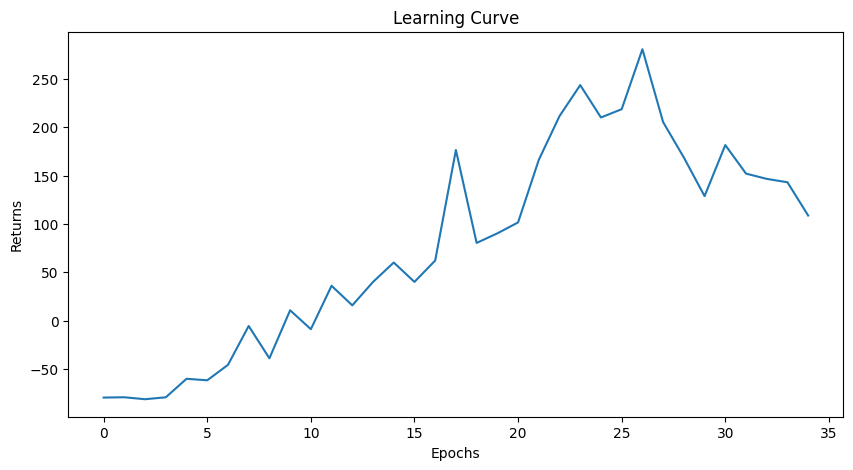

In [ ]:
epochs = range(35)
fig, axes = plt.subplots(figsize=(10, 5))
axes.plot(epochs, stats['Returns'])
axes.set_ylabel('Returns')
axes.set_xlabel('Epochs')
axes.set_title('Learning Curve')

# Test Eval

In [ ]:
try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, *args, **kwargs: x  # Fallback: tqdm becomes a no-op

import warnings
warnings.filterwarnings('ignore')

def eval():
    max_cycles = 300
    env = battle_v4.env(map_size=45, max_cycles=max_cycles)
    # device = "cuda" if torch.cuda.is_available() else "cpu"
    device = "cpu"

    def random_policy(env, agent, obs):
        return env.action_space(agent).sample()

    q_network = QNetwork_pre(
        env.observation_space("red_0").shape, env.action_space("red_0").n
    )
    q_network.load_state_dict(
        torch.load("red.pt", weights_only=True, map_location="cpu")
    )
    q_network.to(device)

    final_q_network = QNetwork_final(
        env.observation_space("red_0").shape, env.action_space("red_0").n
    )
    final_q_network.load_state_dict(
        torch.load("red_final.pt", weights_only=True, map_location="cpu")
    )
    final_q_network.to(device)

    my_q_network = QNetwork(5, 5, 21)
    my_q_network.load_state_dict(
        torch.load("best_model.pt", weights_only=True, map_location="cpu")
    )
    my_q_network.to(device)

    def pretrain_policy(env, agent, obs):
        observation = (
            torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device)
        )
        with torch.no_grad():
            q_values = q_network(observation)
        return torch.argmax(q_values, dim=1).cpu().numpy()[0]

    def final_pretrain_policy(env, agent, obs):
        observation = (
            torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device)
        )
        with torch.no_grad():
            q_values = final_q_network(observation)
        return torch.argmax(q_values, dim=1).cpu().numpy()[0]

    def my_pretrain_policy(env, agent, obs):
        observation = (
            torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device)
        )
        with torch.no_grad():
            q_values = my_q_network(observation)
        return torch.argmax(q_values, dim=1).cpu().numpy()[0]

    def run_eval(env, red_policy, blue_policy, n_episode: int = 100):
        red_win, blue_win = [], []
        red_tot_rw, blue_tot_rw = [], []
        n_agent_each_team = len(env.env.action_spaces) // 2

        for _ in tqdm(range(n_episode)):
            env.reset()
            n_kill = {"red": 0, "blue": 0}
            red_reward, blue_reward = 0, 0

            for agent in env.agent_iter():
                observation, reward, termination, truncation, info = env.last()
                agent_team = agent.split("_")[0]

                n_kill[agent_team] += (
                    reward > 4.5
                )  # This assumes default reward settups
                if agent_team == "red":
                    red_reward += reward
                else:
                    blue_reward += reward

                if termination or truncation:
                    action = None  # this agent has died
                else:
                    if agent_team == "red":
                        action = red_policy(env, agent, observation)
                    else:
                        action = blue_policy(env, agent, observation)

                env.step(action)

            who_wins = "red" if n_kill["red"] >= n_kill["blue"] + 5 else "draw"
            who_wins = "blue" if n_kill["red"] + 5 <= n_kill["blue"] else who_wins
            red_win.append(who_wins == "red")
            blue_win.append(who_wins == "blue")

            red_tot_rw.append(red_reward / n_agent_each_team)
            blue_tot_rw.append(blue_reward / n_agent_each_team)

        return {
            "winrate_red": np.mean(red_win),
            "winrate_blue": np.mean(blue_win),
            "average_rewards_red": np.mean(red_tot_rw),
            "average_rewards_blue": np.mean(blue_tot_rw),
        }

    print("=" * 20)
    print("Eval with random policy")
    print(
        run_eval(
            env=env, red_policy=random_policy, blue_policy=my_pretrain_policy, n_episode=30
        )
    )
    print("=" * 20)

    print("Eval with trained policy")
    print(
        run_eval(
            env=env, red_policy=pretrain_policy, blue_policy=my_pretrain_policy, n_episode=30
        )
    )
    print("=" * 20)

    print("Eval with final trained policy")
    print(
        run_eval(
            env=env, red_policy=final_pretrain_policy, blue_policy=my_pretrain_policy, n_episode=30,
        )
    )
    print("=" * 20)

if __name__ == "__main__":
    eval()

Eval with random policy


100%|██████████| 30/30 [06:31<00:00, 13.05s/it]


{'winrate_red': 0.0, 'winrate_blue': 1.0, 'average_rewards_red': -3.779302602389697, 'average_rewards_blue': -17.5570667387086}
Eval with trained policy


100%|██████████| 30/30 [05:36<00:00, 11.20s/it]


{'winrate_red': 0.0, 'winrate_blue': 1.0, 'average_rewards_red': 1.2101275676405325, 'average_rewards_blue': -11.059405986151043}
Eval with final trained policy


100%|██████████| 30/30 [06:36<00:00, 13.20s/it]

{'winrate_red': 0.0, 'winrate_blue': 1.0, 'average_rewards_red': 1.382224241322972, 'average_rewards_blue': -8.81051700680781}
